In [57]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import models

import numpy as np
import os
import pickle
import random
import matplotlib.pyplot as plt
import seaborn as sns
import time

import importlib
import utils.ml_utils as ml_utils
importlib.reload(ml_utils)

<module 'utils.ml_utils' from '/home/apurvapathak/ml-experiments/utils/ml_utils.py'>

## Init seeds and env variables (makes training deterministic)

In [2]:
ml_utils.init_env()

## Helper Functions

In [3]:
def summarize_activations(stats_by_regularizer, model_state_by_regularizer, sample_batch):
    activation_by_regularizers = {}
    for key, model_state in model_state_by_regularizer.items():
        # Build model and load weights
        use_bn=False
        idx_n_1=16
        idx_n=18
        if key.startswith('bn:'):
            use_bn=True
            idx_n=25
            idx_n_1=22
        model = ml_utils.build_model(conv_dropout_rate=0, dense_dropout_rate=0, use_batch_normalization=use_bn)
        model.load_weights('pickled_objects/regularization/regularizers_{}_best_weights.h5'.format(key))
        layer_outputs = [layer.output for layer in model.layers]
        activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

        activation_n_1 = activation_model.predict(sample_batch[0], steps=1)[idx_n_1]
        activation_n = activation_model.predict(sample_batch[0], steps=1)[idx_n]

        activation_by_regularizers[key]=(activation_n_1,
                                         activation_n, 
                                         sample_batch[1])

        activation_n_1_sum = np.sum(activation_n_1, axis=0)
        non_zero_activation_n_1 = np.average(np.sum(activation_n_1>0, axis=1))
        average_activation_n_1 = np.average(np.sum(abs(activation_n_1), axis=1))

        activation_n_sum = np.sum(activation_n, axis=0)
        non_zero_activation_n = np.average(np.sum(activation_n>0, axis=1))
        average_activation_n = np.average(np.sum(abs(activation_n), axis=1))

        best_val_accuracy = np.max(model_state.history['val_accuracy'])
        best_val_loss = np.min(model_state.history['val_loss'])

        # Summarize activations
        print('Stats for {key} at convergence: '.format(key=key), stats_by_regularizer[key])
        print('Non-zero Activations L(n-1): {non_zero_activations}, Average Activation L(n-1): {average_activation}'.
             format(typ=typ, non_zero_activations=non_zero_activation_n_1, average_activation=average_activation_n_1))
        print('Non-zero Activations Ln: {non_zero_activations}, Average Activation Ln: {average_activation}'.
             format(typ=typ, non_zero_activations=non_zero_activation_n, average_activation=average_activation_n))
        print('\n*********************************************************************\n')

## Read Data

In [4]:
# Constants
IMG_SIZE = 128 # All images in the dataset will be resized to this size
BATCH_SIZE = 32 # Batch size

# Read in training and validation data
train, validation = ml_utils.load_batched_and_resized_dataset(
    dataset_name='cats_and_dogs',
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE
)

Training Data Summary
No. of examples: 18610
Class: 0 :::: Count: 9378 :::: Percentage: 50.39226222461043
Class: 1 :::: Count: 9232 :::: Percentage: 49.60773777538957

Validation Data Summary
No. of examples: 4652
Class: 0 :::: Count: 2280 :::: Percentage: 49.011177987962164
Class: 1 :::: Count: 2372 :::: Percentage: 50.988822012037836


In [5]:
sample_batch=validation.take(1)
np_sample_batch=sample_batch.as_numpy_iterator().next()

## Run All Regularizer Experiments
Apply dropout, L1 and L2 regularizations in dense layers only

In [67]:
#model_state_by_regularizers = {}
model_state_by_regularizers = ml_utils.load_model_state('model_state_by_regularizers_new')

In [60]:
regularizer_configs = [ #dense(dropout, l2, l1, is_dense_only=1)
    (0, 0, 0),
    (0.1, 0, 0),
    (0.2, 0, 0),
    (0.3, 0, 0),
    (0.4, 0, 0),
    (0.5, 0, 0),
    (0.6, 0, 0),
    (0.7, 0, 0),
    (0, 0.0001, 0, 0),
    (0, 0.001, 0, 0),
    (0, 0.0001, 0),
    (0, 0.001, 0),
    (0, 0.01, 0),
    (0, 0.02, 0),
    (0, 0.05, 0),
    (0, 0.1, 0),
    (0, 0, 0.00001),
    (0, 0, 0.0001),
    (0, 0, 0.001),
    (0, 0, 0.002),
    (0, 0, 0.005),
    (0, 0, 0.01)
]

for regularizer_config in regularizer_configs:
    # Read config from regularizer_config
    dropout = regularizer_config[0]
    l2 = regularizer_config[1]
    l1 = regularizer_config[2]
    key = 'dr={dropout}_l2={l2}_l1={l1}'.format(**locals())
    dense_only = len(regularizer_config)==3 or regularizer_config[3]==1
    if dense_only:
        key='dense:'+key
    print('Processing: ', key)
    
    if key in model_state_by_regularizers:
        continue
    
    # Build and train model
    optimizer = keras.optimizers.SGD(learning_rate=0.01)
    model = ml_utils.build_model(
        conv_dropout_rate=0 if dense_only else dropout,
        conv_l2_regularizer=0 if dense_only else l2,
        conv_l1_regularizer=0 if dense_only else l1,
        dense_dropout_rate=dropout,
        dense_l2_regularizer=l2,
        dense_l1_regularizer=l1,
        optimizer=optimizer,
    )
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    mc = keras.callbacks.ModelCheckpoint(
        'pickled_objects/regularization/regularizers_{}_best_weights.h5'.format(key),
        monitor='val_loss',
        mode='min',
        verbose=1,
        save_best_only=True,
        save_weights_only=True
    )
    model_state_by_regularizers[key] = ml_utils.train_model(
        model,
        train,
        validation,
        epochs=1000,
        extra_callbacks=[es, mc],
    )

Processing:  dense:dr=0_l2=0_l1=0
Processing:  dense:dr=0.1_l2=0_l1=0
Processing:  dense:dr=0.2_l2=0_l1=0
Processing:  dense:dr=0.3_l2=0_l1=0
Processing:  dense:dr=0.4_l2=0_l1=0
Processing:  dense:dr=0.5_l2=0_l1=0
Processing:  dense:dr=0.6_l2=0_l1=0
Processing:  dense:dr=0.7_l2=0_l1=0
Processing:  dr=0_l2=0.0001_l1=0
Processing:  dr=0_l2=0.001_l1=0
Processing:  dense:dr=0_l2=0.0001_l1=0
Processing:  dense:dr=0_l2=0.001_l1=0
Processing:  dense:dr=0_l2=0.01_l1=0
Processing:  dense:dr=0_l2=0.02_l1=0
Processing:  dense:dr=0_l2=0.05_l1=0
Processing:  dense:dr=0_l2=0.1_l1=0
Processing:  dense:dr=0_l2=0_l1=1e-05
Processing:  dense:dr=0_l2=0_l1=0.0001
Processing:  dense:dr=0_l2=0_l1=0.001
Processing:  dense:dr=0_l2=0_l1=0.002
Processing:  dense:dr=0_l2=0_l1=0.005
Processing:  dense:dr=0_l2=0_l1=0.01


In [66]:
ml_utils.save_model_state(model_state_by_regularizers, 'model_state_by_regularizers_new')

In [51]:
model_state_by_regularizers.keys()

dict_keys(['dense:dr=0_l2=0_l1=0', 'dense:dr=0.1_l2=0_l1=0', 'dense:dr=0.2_l2=0_l1=0', 'dense:dr=0.3_l2=0_l1=0', 'dense:dr=0.4_l2=0_l1=0', 'dense:dr=0.5_l2=0_l1=0', 'dense:dr=0.6_l2=0_l1=0', 'dense:dr=0.7_l2=0_l1=0', 'dense:dr=0_l2=0.0001_l1=0', 'dense:dr=0_l2=0.001_l1=0', 'dense:dr=0_l2=0.01_l1=0', 'dense:dr=0_l2=0.1_l1=0', 'dr=0_l2=0.0001_l1=0', 'dr=0_l2=0.001_l1=0', 'dense:dr=0_l2=0_l1=1e-05', 'dense:dr=0_l2=0_l1=0.0001', 'dense:dr=0_l2=0_l1=0.001', 'dense:dr=0_l2=0_l1=0.01', 'bn:dense:dr=0_l2=0_l1=0', 'bn:dense:dr=0.4_l2=0_l1=0', 'bn:dense:dr=0_l2=0.01_l1=0', 'bn:dense:dr=0_l2=0_l1=0.001', 'bn:dense:dr=0.6_l2=0_l1=0', 'dense:dr=0_l2=0.05_l1=0', 'dense:dr=0_l2=0_l1=0.005', 'bn:dense:dr=0_l2=0.05_l1=0', 'bn:dense:dr=0_l2=1_l1=0', 'bn:dense:dr=0_l2=0_l1=0.005', 'bn:dense:dr=0.5_l2=0.01_l1=0', 'bn:dense:dr=0.5_l2=0.31622776601683794_l1=0', 'bn:dense:dr=0.5_l2=10.0_l1=0', 'bn:dense:dr=0.6_l2=0.01_l1=0', 'bn:dense:dr=0.6_l2=0.31622776601683794_l1=0', 'bn:dense:dr=0.6_l2=10.0_l1=0', 'bn:d

## Regularizers
We are going to compare the following regularization techniques in this notebook:
    1. Dropout
    2. L2 Regularization
    3. L1 Regularization
    4. Batch Normalization

### 1. Dropout
The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

Note that the Dropout layer only applies when training is set to True such that no values are dropped during inference. When using model.fit, training will be appropriately set to True automatically, and in other contexts, you can set the kwarg explicitly to True when calling the layer.

In [43]:
model_state_by_dropout={}
for regularizer_config in [ # dense(dropout, l2, l1)
    (0, 0, 0),
    (0.1, 0, 0),
    (0.2, 0, 0),
    (0.3, 0, 0),
    (0.4, 0, 0),
    (0.5, 0, 0),
    (0.6, 0, 0),
    (0.7, 0, 0)
]:
    # Read config from regularizer_config
    dropout = regularizer_config[0]
    l2 = regularizer_config[1]
    l1 = regularizer_config[2]
    dense_only = len(regularizer_config)==3 or regularizer_config[3]==1
    key = 'dr={dropout}_l2={l2}_l1={l1}'.format(**locals())
    if dense_only:
        key='dense:'+key
    model_state_by_dropout[key] = model_state_by_regularizers[key]

#### Summarize Results
We observed around 3.5% accuracy gain as a result of applying dropout. It also closed the generalization gap between train and test loss. The best loss value was: 0.3443 when dropout was set at 0.7

In [61]:
stats_by_regularizer={}
for key,model_state in model_state_by_dropout.items():
    best_epoch=np.argmin(model_state.history['val_loss'])
    stats={}
    stats['train_loss']=model_state.history['loss'][best_epoch]
    stats['val_loss']=model_state.history['val_loss'][best_epoch]
    stats['train_accuracy']=model_state.history['accuracy'][best_epoch]
    stats['val_accuracy']=model_state.history['val_accuracy'][best_epoch]
    stats_by_regularizer[key]=stats
    print('Stats for {key} at convergence: '.format(key=key), stats)
    

Stats for dense:dr=0_l2=0_l1=0 at convergence:  {'train_loss': 0.36424958094802357, 'val_loss': 0.42026286776343436, 'train_accuracy': 0.8418592, 'val_accuracy': 0.8114789}
Stats for dense:dr=0.1_l2=0_l1=0 at convergence:  {'train_loss': 0.3177099390705064, 'val_loss': 0.40476633516484745, 'train_accuracy': 0.8624396, 'val_accuracy': 0.81362855}
Stats for dense:dr=0.2_l2=0_l1=0 at convergence:  {'train_loss': 0.33321973066506755, 'val_loss': 0.38834282990596064, 'train_accuracy': 0.85626006, 'val_accuracy': 0.8248065}
Stats for dense:dr=0.3_l2=0_l1=0 at convergence:  {'train_loss': 0.30397639945910093, 'val_loss': 0.3774198106911084, 'train_accuracy': 0.8738313, 'val_accuracy': 0.8299656}
Stats for dense:dr=0.4_l2=0_l1=0 at convergence:  {'train_loss': 0.2967615261441722, 'val_loss': 0.3466812000699239, 'train_accuracy': 0.8747985, 'val_accuracy': 0.84845227}
Stats for dense:dr=0.5_l2=0_l1=0 at convergence:  {'train_loss': 0.32401560087923975, 'val_loss': 0.35537064044851147, 'train_ac

#### Loss

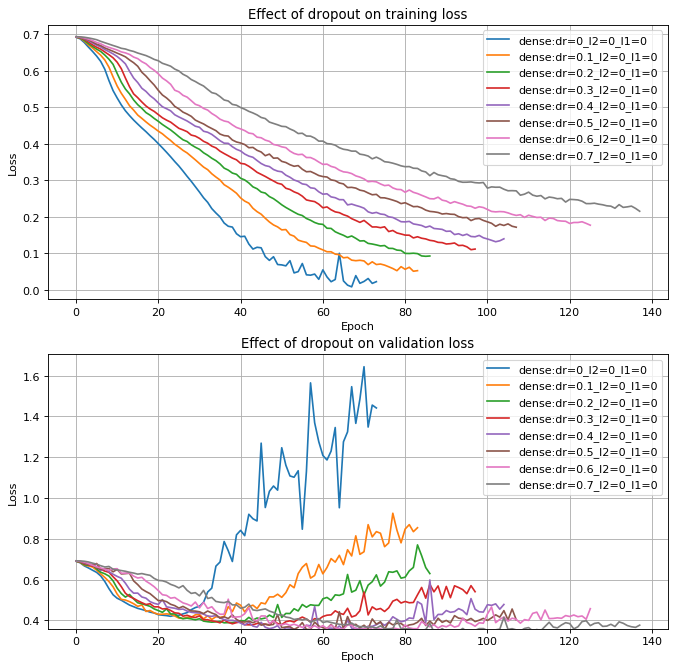

<Figure size 432x288 with 0 Axes>

In [62]:
ml_utils.plot_loss_by_param(model_state_by_dropout, 'dropout', 'dropout_loss')

#### Accuracy

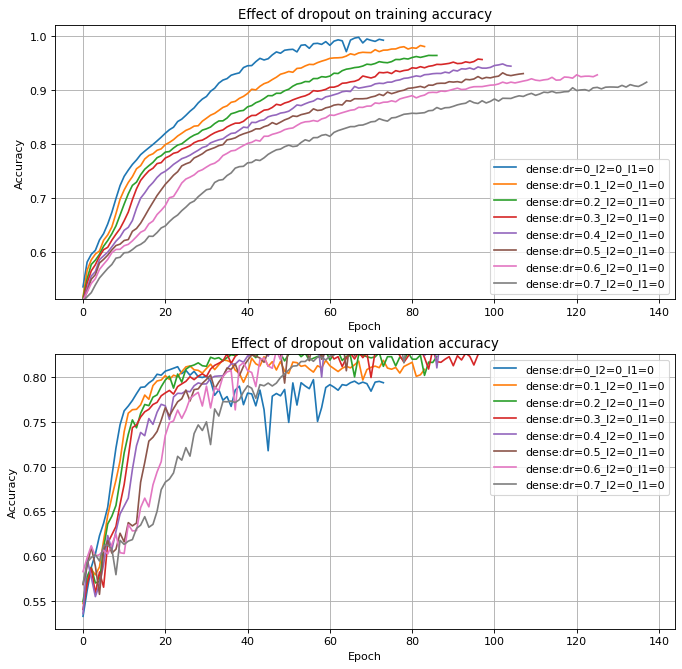

<Figure size 432x288 with 0 Axes>

In [63]:
ml_utils.plot_accuracies_by_param(model_state_by_dropout, 'dropout', 'dropout_accuracy')

#### Generalization Gap
Generalization gap is defined as the ratio of validation loss and training loss. The idea value for this is 1. For the ease of visualization we have clipped this value at 5. As we can see that the generalization gap becomes better as we increase the dropout rate.

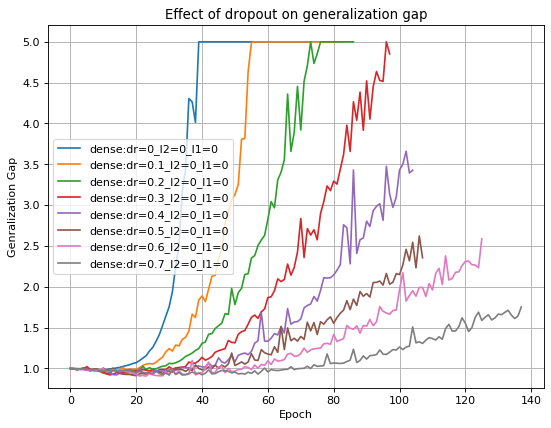

In [64]:
ml_utils.plot_generalization_gap_by_param(model_state_by_dropout, 'dropout', 'dropout_gen_gap', 5)

#### Weight Visualization
Dropout doesn't have an effect on weights distribution

Model: dense:dr=0_l2=0_l1=0, Max Weight: 0.15175209939479828, Min Weight: 0.15175209939479828
Model: dense:dr=0.2_l2=0_l1=0, Max Weight: 0.14678001403808594, Min Weight: 0.14678001403808594
Model: dense:dr=0.4_l2=0_l1=0, Max Weight: 0.14278064668178558, Min Weight: 0.14278064668178558
Model: dense:dr=0.6_l2=0_l1=0, Max Weight: 0.14343120157718658, Min Weight: 0.14343120157718658


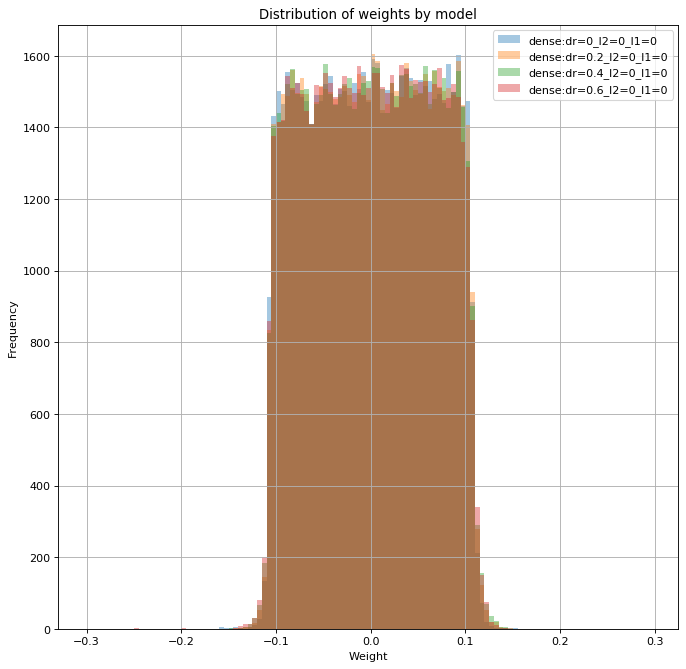

In [65]:
model_weights_by_regularizers = {}

for key in [
    'dense:dr=0_l2=0_l1=0',
    'dense:dr=0.2_l2=0_l1=0',
    'dense:dr=0.4_l2=0_l1=0',
    'dense:dr=0.6_l2=0_l1=0'
]:
    use_bn=False
    weight_index=12
    if key.startswith('bn:'):
        use_bn=True
        weight_index=40
    model = ml_utils.build_model(conv_dropout_rate=0, dense_dropout_rate=0, use_batch_normalization=use_bn)
    model.load_weights('pickled_objects/regularization/regularizers_{}_best_weights.h5'.format(key))
    model_weights_by_regularizers[key] = model.get_weights()[weight_index]
    
ml_utils.visualize_weights(model_weights_by_regularizers, 'weights_by_dropout')

#### Activation Visualization
As we increase the droput, the no. of nodes with zero activations across all layers go up. The average activation value however didn't change much.

In [127]:
summarize_activations(stats_by_regularizer, model_state_by_dropout, np_sample_batch)

Stats for dense:dr=0_l2=0_l1=0 at convergence:  {'train_loss': 0.36424958094802357, 'val_loss': 0.42026286776343436, 'train_accuracy': 0.8418592, 'val_accuracy': 0.8114789}
Non-zero Activations L(n-1): 142.65625, Average Activation L(n-1): 38.052757263183594
Non-zero Activations Ln: 156.65625, Average Activation Ln: 35.702171325683594

*********************************************************************

Stats for dense:dr=0.1_l2=0_l1=0 at convergence:  {'train_loss': 0.3177099390705064, 'val_loss': 0.40476633516484745, 'train_accuracy': 0.8624396, 'val_accuracy': 0.81362855}
Non-zero Activations L(n-1): 132.25, Average Activation L(n-1): 24.096683502197266
Non-zero Activations Ln: 155.90625, Average Activation Ln: 29.360998153686523

*********************************************************************

Stats for dense:dr=0.2_l2=0_l1=0 at convergence:  {'train_loss': 0.33321973066506755, 'val_loss': 0.38834282990596064, 'train_accuracy': 0.85626006, 'val_accuracy': 0.8248065}
Non-zer

### 2. L2 Regularization

In [12]:
model_state_by_l2={}
for regularizer_config in [ # dense(dropout, l2, l1)
    (0, 0, 0),
    (0, 0.0001, 0, 0),
    (0, 0.001, 0, 0),
    (0, 0.01, 0, 0),
    (0, 0.0001, 0),
    (0, 0.001, 0),
    (0, 0.01, 0),
    (0, 0.02, 0),
    (0, 0.05, 0),
    (0, 0.1, 0),
]:
    # Read config from regularizer_config
    dropout = regularizer_config[0]
    l2 = regularizer_config[1]
    l1 = regularizer_config[2]
    dense_only = len(regularizer_config)==3 or regularizer_config[3]==1
    key = 'dr={dropout}_l2={l2}_l1={l1}'.format(**locals())
    if dense_only:
        key='dense:'+key
    if key in model_state_by_regularizers:
        model_state_by_l2[key] = model_state_by_regularizers[key] #model_state_by_regularizers[key]

#### Summarize Results
Surprisingly L2 Regularization didn't help increase validation accuracy a lot. 

In [124]:
for key,model_state in model_state_by_l2.items():
    best_epoch=np.argmin(model_state.history['val_loss'])
    stats={}
    stats['train_loss']=model_state.history['loss'][best_epoch]
    stats['val_loss']=model_state.history['val_loss'][best_epoch]
    stats['train_accuracy']=model_state.history['accuracy'][best_epoch]
    stats['val_accuracy']=model_state.history['val_accuracy'][best_epoch]
    stats_by_regularizer[key]=stats
    print('Stats for {key} at convergence: '.format(key=key), stats)
    

Stats for dense:dr=0_l2=0_l1=0 at convergence:  {'train_loss': 0.36424958094802357, 'val_loss': 0.42026286776343436, 'train_accuracy': 0.8418592, 'val_accuracy': 0.8114789}
Stats for dr=0_l2=0.0001_l1=0 at convergence:  {'train_loss': 0.430375275193588, 'val_loss': 0.49624941549072527, 'train_accuracy': 0.84519076, 'val_accuracy': 0.80803955}
Stats for dr=0_l2=0.001_l1=0 at convergence:  {'train_loss': 0.7016691104690597, 'val_loss': 0.8106147793874349, 'train_accuracy': 0.86786675, 'val_accuracy': 0.8099742}
Stats for dense:dr=0_l2=0.0001_l1=0 at convergence:  {'train_loss': 0.4430256077418207, 'val_loss': 0.4885682267685459, 'train_accuracy': 0.8337453, 'val_accuracy': 0.8078246}
Stats for dense:dr=0_l2=0.001_l1=0 at convergence:  {'train_loss': 0.6658102157229957, 'val_loss': 0.7757858580922428, 'train_accuracy': 0.8654487, 'val_accuracy': 0.80546004}
Stats for dense:dr=0_l2=0.01_l1=0 at convergence:  {'train_loss': 0.4552440826576413, 'val_loss': 0.4932217336680791, 'train_accuracy

#### Loss

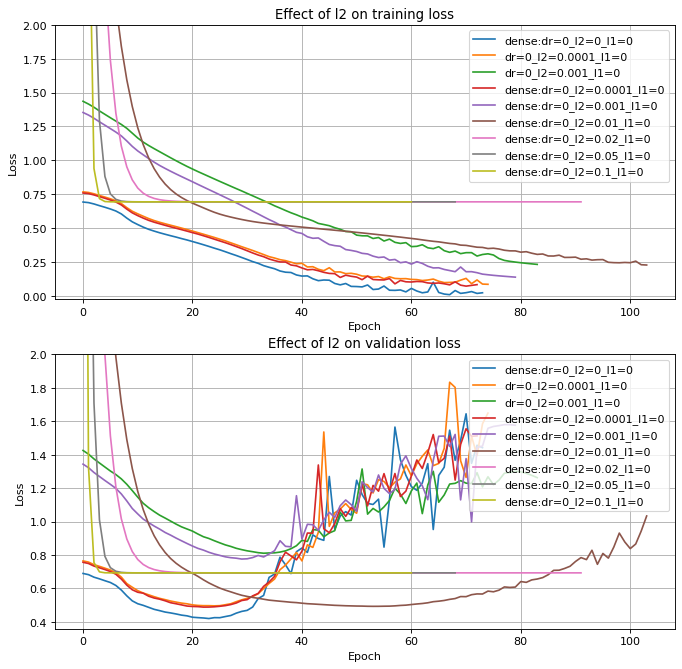

<Figure size 432x288 with 0 Axes>

In [14]:
ml_utils.plot_loss_by_param(model_state_by_l2, 'l2', 'l2_loss', ylim_right=2)

#### Accuracy

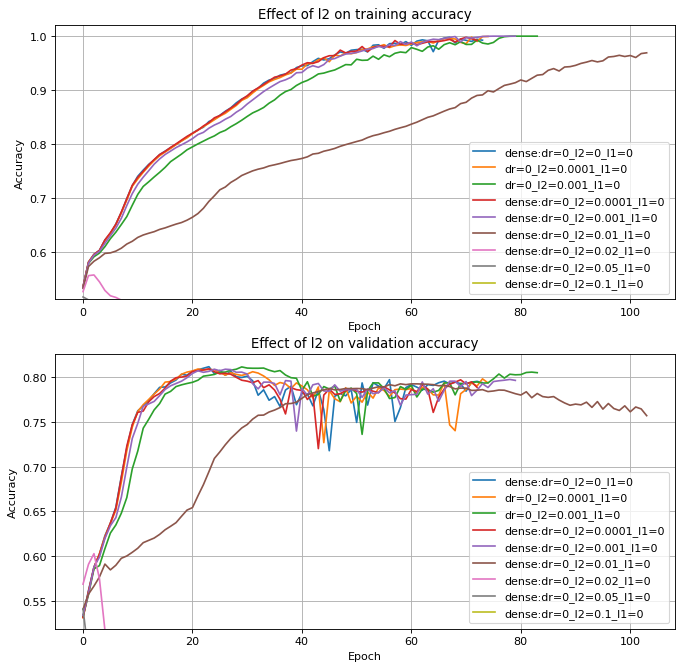

<Figure size 432x288 with 0 Axes>

In [15]:
ml_utils.plot_accuracies_by_param(model_state_by_l2, 'l2', 'l2_accuracy')

#### Generalization Gap

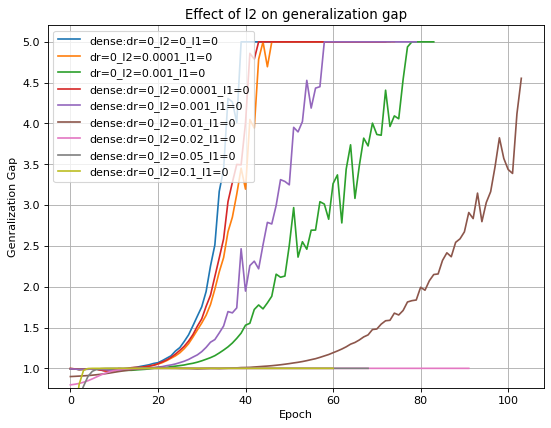

In [16]:
ml_utils.plot_generalization_gap_by_param(model_state_by_l2, 'l2', 'l2_gen_gap', 5)

#### Weight Visualization
Weights are distributed by guassian as a result of applying L2 norm. The standard deviation reduces as we increase the l2 regularization scalar.

Model: dense:dr=0_l2=0_l1=0, Max Weight: 0.15175209939479828, Min Weight: 0.15175209939479828
Model: dense:dr=0_l2=0.0001_l1=0, Max Weight: 0.14537467062473297, Min Weight: 0.14537467062473297
Model: dense:dr=0_l2=0.001_l1=0, Max Weight: 0.1363087147474289, Min Weight: 0.1363087147474289
Model: dense:dr=0_l2=0.01_l1=0, Max Weight: 0.070401132106781, Min Weight: 0.070401132106781


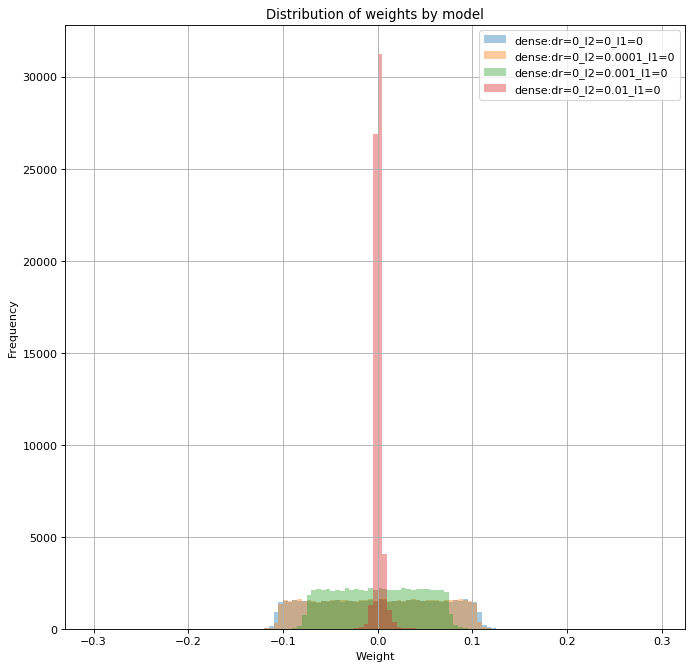

In [160]:
model_weights_by_regularizers = {}

for key in [
    'dense:dr=0_l2=0_l1=0',
    'dense:dr=0_l2=0.0001_l1=0',
    'dense:dr=0_l2=0.001_l1=0',
    'dense:dr=0_l2=0.01_l1=0'
]:
    use_bn=False
    weight_index=12
    if key.startswith('bn:'):
        use_bn=True
        weight_index=40
    model = ml_utils.build_model(conv_dropout_rate=0, dense_dropout_rate=0, use_batch_normalization=use_bn)
    model.load_weights('pickled_objects/regularization/regularizers_{}_best_weights.h5'.format(key))
    model_weights_by_regularizers[key] = model.get_weights()[weight_index]
    
ml_utils.visualize_weights(model_weights_by_regularizers, 'weights_by_l2')

#### Activation Visualization
The average activations are really small whenever the model doesn't converge.

In [128]:
summarize_activations(stats_by_regularizer, model_state_by_l2, np_sample_batch)

Stats for dense:dr=0_l2=0_l1=0 at convergence:  {'train_loss': 0.36424958094802357, 'val_loss': 0.42026286776343436, 'train_accuracy': 0.8418592, 'val_accuracy': 0.8114789}
Non-zero Activations L(n-1): 142.65625, Average Activation L(n-1): 38.052757263183594
Non-zero Activations Ln: 156.65625, Average Activation Ln: 35.702171325683594

*********************************************************************

Stats for dr=0_l2=0.0001_l1=0 at convergence:  {'train_loss': 0.430375275193588, 'val_loss': 0.49624941549072527, 'train_accuracy': 0.84519076, 'val_accuracy': 0.80803955}
Non-zero Activations L(n-1): 143.59375, Average Activation L(n-1): 37.26097106933594
Non-zero Activations Ln: 157.3125, Average Activation Ln: 34.68184280395508

*********************************************************************

Stats for dr=0_l2=0.001_l1=0 at convergence:  {'train_loss': 0.7016691104690597, 'val_loss': 0.8106147793874349, 'train_accuracy': 0.86786675, 'val_accuracy': 0.8099742}
Non-zero Activat

### 3. L1 Regularization

In [17]:
model_state_by_l1={}
for regularizer_config in [ # dense(dropout, l2, l1)
    (0, 0, 0),
    (0, 0, 0.00001),
    (0, 0, 0.0001),
    (0, 0, 0.001),
    (0, 0, 0.002),
    (0, 0, 0.005),
    (0, 0, 0.01),
]:
    # Read config from regularizer_config
    dropout = regularizer_config[0]
    l2 = regularizer_config[1]
    l1 = regularizer_config[2]
    dense_only = len(regularizer_config)==3 or regularizer_config[3]==1
    key = 'dr={dropout}_l2={l2}_l1={l1}'.format(**locals())
    if dense_only:
        key='dense:'+key
    if key in model_state_by_regularizers:
        model_state_by_l1[key] = model_state_by_regularizers[key] #model_state_by_regularizers[key]

#### Summarize Results
Surprisingly L1 Regularization didn't help increase validation accuracy a lot. 

In [121]:
for key,model_state in model_state_by_l1.items():
    best_epoch=np.argmin(model_state.history['val_loss'])
    stats={}
    stats['train_loss']=model_state.history['loss'][best_epoch]
    stats['val_loss']=model_state.history['val_loss'][best_epoch]
    stats['train_accuracy']=model_state.history['accuracy'][best_epoch]
    stats['val_accuracy']=model_state.history['val_accuracy'][best_epoch]
    stats_by_regularizer[key]=stats
    print('Stats for {key} at convergence: '.format(key=key), stats)
    

Stats for dense:dr=0_l2=0_l1=0 at convergence:  {'train_loss': 0.36424958094802357, 'val_loss': 0.42026286776343436, 'train_accuracy': 0.8418592, 'val_accuracy': 0.8114789}
Stats for dense:dr=0_l2=0_l1=1e-05 at convergence:  {'train_loss': 0.4739106807511446, 'val_loss': 0.5389250641408032, 'train_accuracy': 0.846964, 'val_accuracy': 0.8086844}
Stats for dense:dr=0_l2=0_l1=0.0001 at convergence:  {'train_loss': 0.9501155155311023, 'val_loss': 1.1824969077763492, 'train_accuracy': 0.9039764, 'val_accuracy': 0.79084265}
Stats for dense:dr=0_l2=0_l1=0.001 at convergence:  {'train_loss': 0.4011259265864555, 'val_loss': 0.45383960161715337, 'train_accuracy': 0.8394412, 'val_accuracy': 0.8101892}
Stats for dense:dr=0_l2=0_l1=0.002 at convergence:  {'train_loss': 0.6997422728789615, 'val_loss': 0.6998087375947873, 'train_accuracy': 0.5032778, 'val_accuracy': 0.49011177}
Stats for dense:dr=0_l2=0_l1=0.005 at convergence:  {'train_loss': 0.7342533875062606, 'val_loss': 0.734181285312731, 'train

#### Loss

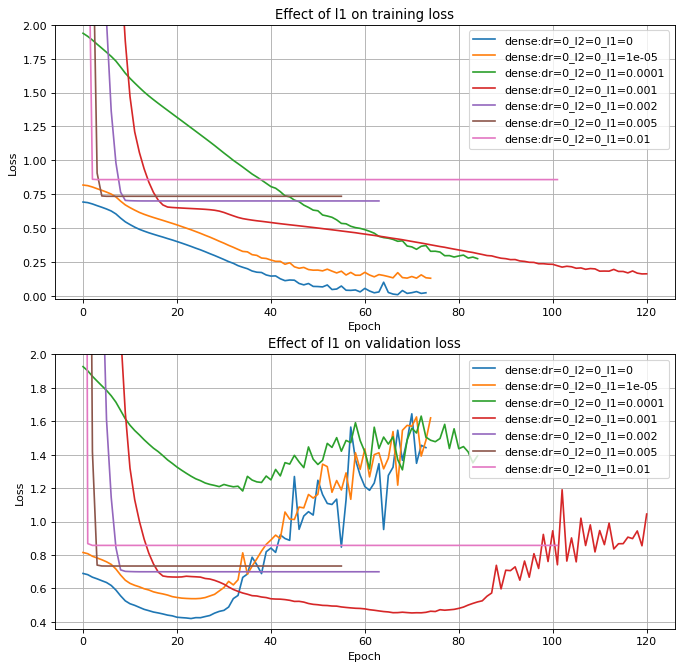

<Figure size 432x288 with 0 Axes>

In [19]:
ml_utils.plot_loss_by_param(model_state_by_l1, 'l1', 'l1_loss', ylim_right=2)

#### Accuracy

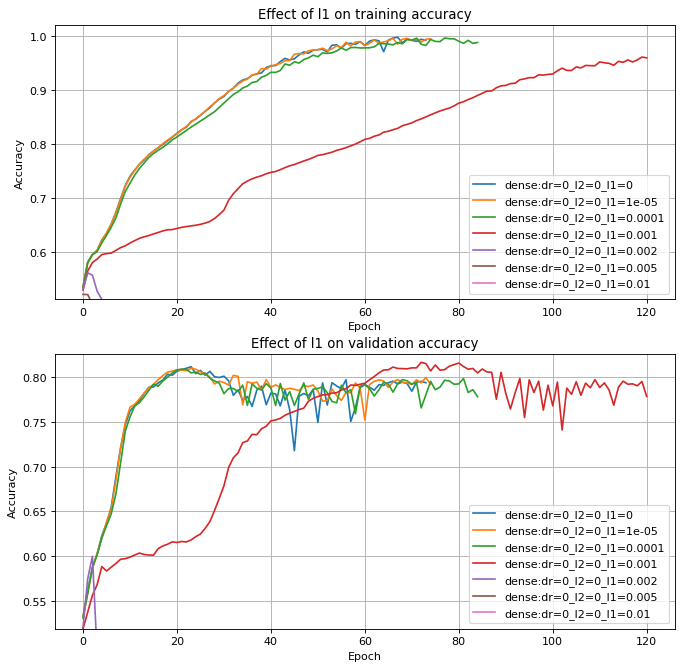

<Figure size 432x288 with 0 Axes>

In [20]:
ml_utils.plot_accuracies_by_param(model_state_by_l1, 'l1', 'l1_accuracy')

#### Generalization Gap

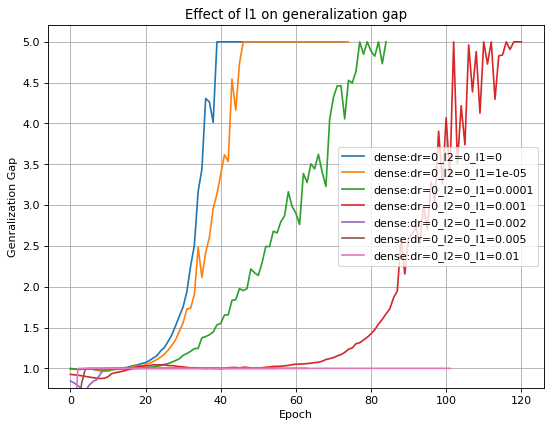

In [21]:
ml_utils.plot_generalization_gap_by_param(model_state_by_l1, 'l1', 'l1_gen_gap', 5)

#### Weight Visualization

Model: dense:dr=0_l2=0_l1=0, Max Weight: 0.15175209939479828, Min Weight: 0.15175209939479828
Model: dense:dr=0_l2=0_l1=1e-05, Max Weight: 0.1531360149383545, Min Weight: 0.1531360149383545
Model: dense:dr=0_l2=0_l1=0.0001, Max Weight: 0.17068800330162048, Min Weight: 0.17068800330162048
Model: dense:dr=0_l2=0_l1=0.001, Max Weight: 0.6767701506614685, Min Weight: 0.6767701506614685


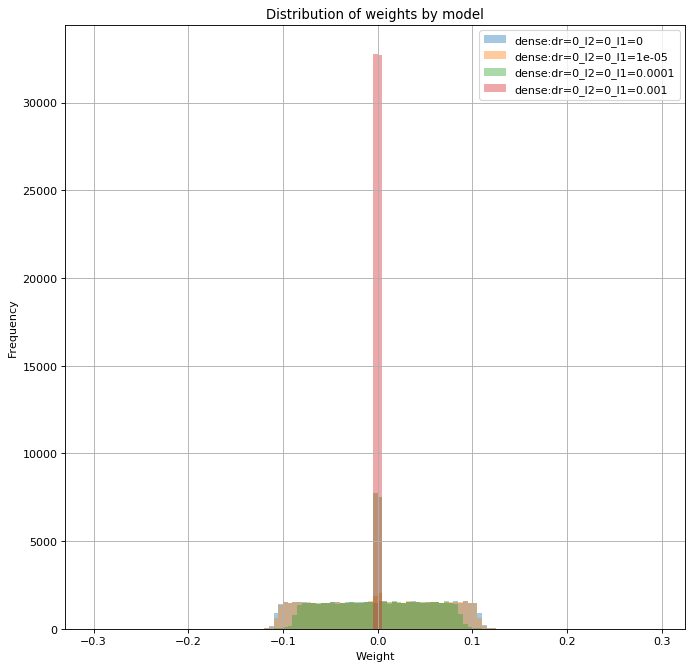

In [157]:
model_weights_by_regularizers = {}

for key in [
    'dense:dr=0_l2=0_l1=0',
    'dense:dr=0_l2=0_l1=1e-05',
    'dense:dr=0_l2=0_l1=0.0001',
    'dense:dr=0_l2=0_l1=0.001'
]:
    use_bn=False
    weight_index=12
    if key.startswith('bn:'):
        use_bn=True
        weight_index=40
    model = ml_utils.build_model(conv_dropout_rate=0, dense_dropout_rate=0, use_batch_normalization=use_bn)
    model.load_weights('pickled_objects/regularization/regularizers_{}_best_weights.h5'.format(key))
    model_weights_by_regularizers[key] = model.get_weights()[weight_index]
    
ml_utils.visualize_weights(model_weights_by_regularizers, 'weights_by_l1')

#### Activation Visualization

In [129]:
summarize_activations(stats_by_regularizer, model_state_by_l1, np_sample_batch)

Stats for dense:dr=0_l2=0_l1=0 at convergence:  {'train_loss': 0.36424958094802357, 'val_loss': 0.42026286776343436, 'train_accuracy': 0.8418592, 'val_accuracy': 0.8114789}
Non-zero Activations L(n-1): 142.65625, Average Activation L(n-1): 38.052757263183594
Non-zero Activations Ln: 156.65625, Average Activation Ln: 35.702171325683594

*********************************************************************

Stats for dense:dr=0_l2=0_l1=1e-05 at convergence:  {'train_loss': 0.4739106807511446, 'val_loss': 0.5389250641408032, 'train_accuracy': 0.846964, 'val_accuracy': 0.8086844}
Non-zero Activations L(n-1): 143.5, Average Activation L(n-1): 38.48678207397461
Non-zero Activations Ln: 155.75, Average Activation Ln: 36.27257537841797

*********************************************************************

Stats for dense:dr=0_l2=0_l1=0.0001 at convergence:  {'train_loss': 0.9501155155311023, 'val_loss': 1.1824969077763492, 'train_accuracy': 0.9039764, 'val_accuracy': 0.79084265}
Non-zero Acti

### 4. Batch Normalization
Use the best of Dropout, L2 Regularization and L1 Regularization with Batch Normalization

In [22]:
for regularizer_config in [ # dense(dropout, l2, l1)
    (0, 0, 0),
    (0.4, 0, 0),
    (0.6, 0, 0),
    (0, 0.01, 0),
    (0, 0.05, 0),
    (0, 1, 0),
    (0, 0, 0.001),
    (0, 0, 0.005),
]:
    # Read config from regularizer_config
    dropout = regularizer_config[0]
    l2 = regularizer_config[1]
    l1 = regularizer_config[2]
    dense_only = len(regularizer_config)==3 or regularizer_config[3]==1
    key = 'dr={dropout}_l2={l2}_l1={l1}'.format(**locals())
    if dense_only:
        key='dense:'+key
    key='bn:' + key
    print('Processing: ', key)
    
    if key in model_state_by_regularizers:
        continue
    
    # Build and train model
    optimizer = keras.optimizers.SGD(learning_rate=0.01)
    model = ml_utils.build_model(
        conv_dropout_rate=0 if dense_only else dropout,
        conv_l2_regularizer=0 if dense_only else l2,
        conv_l1_regularizer=0 if dense_only else l1,
        dense_dropout_rate=dropout,
        dense_l2_regularizer=l2,
        dense_l1_regularizer=l1,
        optimizer=optimizer,
        use_batch_normalization=True
    )
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    mc = keras.callbacks.ModelCheckpoint(
        'pickled_objects/regularization/regularizers_{}_best_weights.h5'.format(key),
        monitor='val_loss',
        mode='min',
        verbose=1,
        save_best_only=True,
        save_weights_only=True
    )
    model_state_by_regularizers[key] = ml_utils.train_model(
        model,
        train,
        validation,
        epochs=1000,
        extra_callbacks=[es, mc],
    )

Processing:  bn:dense:dr=0_l2=0_l1=0
Processing:  bn:dense:dr=0.4_l2=0_l1=0
Processing:  bn:dense:dr=0.6_l2=0_l1=0
Processing:  bn:dense:dr=0_l2=0.01_l1=0
Processing:  bn:dense:dr=0_l2=0.05_l1=0
Processing:  bn:dense:dr=0_l2=1_l1=0
Processing:  bn:dense:dr=0_l2=0_l1=0.001
Processing:  bn:dense:dr=0_l2=0_l1=0.005


In [23]:
model_state_by_bn={}
model_state_by_bn['dense:dr=0_l2=0_l1=0']=model_state_by_regularizers['dense:dr=0_l2=0_l1=0']
for regularizer_config in [ # dense(dropout, l2, l1)
    (0, 0, 0),
    (0.4, 0, 0),
    (0.6, 0, 0),
    (0, 0.01, 0),
    (0, 0.05, 0),
    (0, 1, 0),
    (0, 0, 0.001),
    (0, 0, 0.005),
]:
    # Read config from regularizer_config
    dropout = regularizer_config[0]
    l2 = regularizer_config[1]
    l1 = regularizer_config[2]
    dense_only = len(regularizer_config)==3 or regularizer_config[3]==1
    key = 'dr={dropout}_l2={l2}_l1={l1}'.format(**locals())
    if dense_only:
        key='dense:'+key
    key='bn:'+key
    if key in model_state_by_regularizers:
        model_state_by_bn[key] = model_state_by_regularizers[key] #model_state_by_regularizers[key]

#### Summarize Results

In [131]:
for key,model_state in model_state_by_bn.items():
    best_epoch=np.argmin(model_state.history['val_loss'])
    stats={}
    stats['train_loss']=model_state.history['loss'][best_epoch]
    stats['val_loss']=model_state.history['val_loss'][best_epoch]
    stats['train_accuracy']=model_state.history['accuracy'][best_epoch]
    stats['val_accuracy']=model_state.history['val_accuracy'][best_epoch]
    stats_by_regularizer[key]=stats
    print('Stats for {key} at convergence: '.format(key=key), stats)
    

Stats for dense:dr=0_l2=0_l1=0 at convergence:  {'train_loss': 0.36424958094802357, 'val_loss': 0.42026286776343436, 'train_accuracy': 0.8418592, 'val_accuracy': 0.8114789}
Stats for bn:dense:dr=0_l2=0_l1=0 at convergence:  {'train_loss': 0.4835080045836386, 'val_loss': 0.5069796144962311, 'train_accuracy': 0.76518, 'val_accuracy': 0.75687873}
Stats for bn:dense:dr=0.4_l2=0_l1=0 at convergence:  {'train_loss': 0.31285626659272886, 'val_loss': 0.3755742063465184, 'train_accuracy': 0.8624933, 'val_accuracy': 0.8411436}
Stats for bn:dense:dr=0.6_l2=0_l1=0 at convergence:  {'train_loss': 0.2724382679679264, 'val_loss': 0.35240566850422994, 'train_accuracy': 0.8839871, 'val_accuracy': 0.8531814}
Stats for bn:dense:dr=0_l2=0.01_l1=0 at convergence:  {'train_loss': 0.17298688962855435, 'val_loss': 0.9101071275056225, 'train_accuracy': 0.98409456, 'val_accuracy': 0.799871}
Stats for bn:dense:dr=0_l2=0.05_l1=0 at convergence:  {'train_loss': 0.5511659632761718, 'val_loss': 0.630058860125607, 't

#### Loss
Batch norm significantly increases the speed of convergence

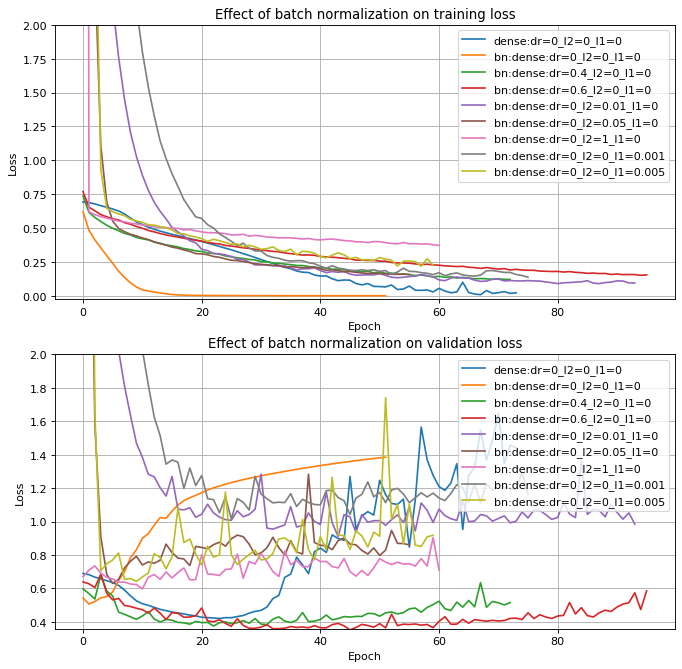

<Figure size 432x288 with 0 Axes>

In [25]:
ml_utils.plot_loss_by_param(model_state_by_bn, 'batch normalization', 'bn_loss', ylim_right=2)

#### Accuracy

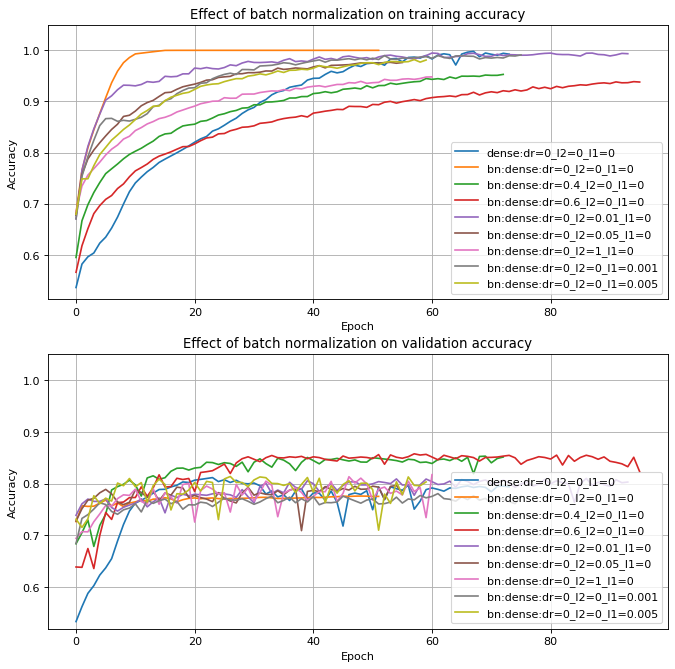

<Figure size 432x288 with 0 Axes>

In [26]:
ml_utils.plot_accuracies_by_param(model_state_by_bn, 'batch normalization', 'bn_accuracy', ylim_right=1.05)

#### Generalization Gap

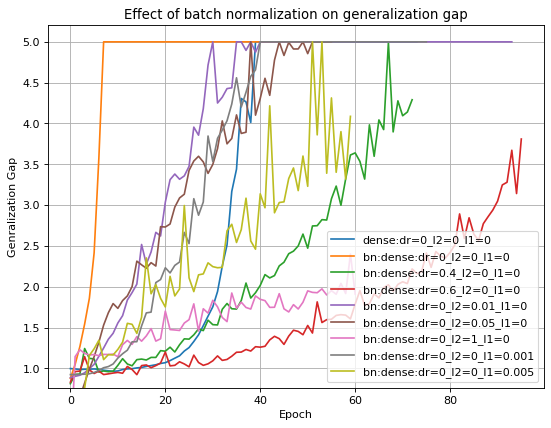

In [132]:
ml_utils.plot_generalization_gap_by_param(model_state_by_bn, 'batch normalization', 'bn_gen_gap', 5)

#### Weight Visualization
Batch Norm doesn't have any effect on the weight distrbution.

Model: dense:dr=0_l2=0_l1=0, Max Weight: 0.15175209939479828, Min Weight: 0.15175209939479828
Model: bn:dense:dr=0_l2=0_l1=0, Max Weight: 0.11604121327400208, Min Weight: 0.11604121327400208
Model: bn:dense:dr=0.4_l2=0_l1=0, Max Weight: 0.1318558156490326, Min Weight: 0.1318558156490326
Model: bn:dense:dr=0.6_l2=0_l1=0, Max Weight: 0.14206580817699432, Min Weight: 0.14206580817699432


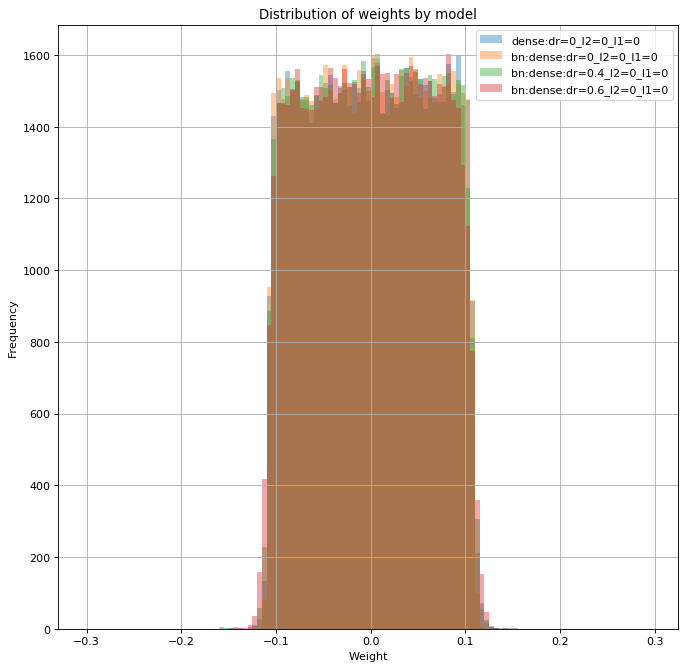

In [153]:
model_weights_by_regularizers = {}

for key in [
    'dense:dr=0_l2=0_l1=0',
    'bn:dense:dr=0_l2=0_l1=0',
    'bn:dense:dr=0.4_l2=0_l1=0',
    'bn:dense:dr=0.6_l2=0_l1=0'
]:
    use_bn=False
    weight_index=12
    if key.startswith('bn:'):
        use_bn=True
        weight_index=40
    model = ml_utils.build_model(conv_dropout_rate=0, dense_dropout_rate=0, use_batch_normalization=use_bn)
    model.load_weights('pickled_objects/regularization/regularizers_{}_best_weights.h5'.format(key))
    model_weights_by_regularizers[key] = model.get_weights()[weight_index]
    
ml_utils.visualize_weights(model_weights_by_regularizers, 'weights_by_dropout')

#### Activation Visualization
The scale of node activation value goes up significantly higher as a result of using Batch Norm. The non-zero activations doesn't change even when applying dropout when we use batch norm.

In [133]:
summarize_activations(stats_by_regularizer, model_state_by_bn, np_sample_batch)

Stats for dense:dr=0_l2=0_l1=0 at convergence:  {'train_loss': 0.36424958094802357, 'val_loss': 0.42026286776343436, 'train_accuracy': 0.8418592, 'val_accuracy': 0.8114789}
Non-zero Activations L(n-1): 142.65625, Average Activation L(n-1): 38.052757263183594
Non-zero Activations Ln: 156.65625, Average Activation Ln: 35.702171325683594

*********************************************************************

Stats for bn:dense:dr=0_l2=0_l1=0 at convergence:  {'train_loss': 0.4835080045836386, 'val_loss': 0.5069796144962311, 'train_accuracy': 0.76518, 'val_accuracy': 0.75687873}
Non-zero Activations L(n-1): 138.59375, Average Activation L(n-1): 218.00045776367188
Non-zero Activations Ln: 127.625, Average Activation Ln: 102.77838134765625

*********************************************************************

Stats for bn:dense:dr=0.4_l2=0_l1=0 at convergence:  {'train_loss': 0.31285626659272886, 'val_loss': 0.3755742063465184, 'train_accuracy': 0.8624933, 'val_accuracy': 0.8411436}
Non-zer

## Using a combination of BN, Dropout and L2

In [28]:
dropout_rate = np.linspace(0.5, 0.7, 3)
l2_rate = np.power(10, np.linspace(-2, 1, 3))

for d in dropout_rate:
    for l in l2_rate:
        regularizer_config=(d,l,0)
        dropout = regularizer_config[0]
        l2 = regularizer_config[1]
        l1 = regularizer_config[2]
        dense_only = len(regularizer_config)==3 or regularizer_config[3]==1
        key = 'dr={dropout}_l2={l2}_l1={l1}'.format(**locals())
        if dense_only:
            key='dense:'+key
        key='bn:' + key
        print('Processing: ', key)

        if key in model_state_by_regularizers:
            continue

        # Build and train model
        optimizer = keras.optimizers.SGD(learning_rate=0.01)
        model = ml_utils.build_model(
            conv_dropout_rate=0 if dense_only else dropout,
            conv_l2_regularizer=0 if dense_only else l2,
            conv_l1_regularizer=0 if dense_only else l1,
            dense_dropout_rate=dropout,
            dense_l2_regularizer=l2,
            dense_l1_regularizer=l1,
            optimizer=optimizer,
            use_batch_normalization=True
        )
        es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
        mc = keras.callbacks.ModelCheckpoint(
            'pickled_objects/regularization/regularizers_{}_best_weights.h5'.format(key),
            monitor='val_loss',
            mode='min',
            verbose=1,
            save_best_only=True,
            save_weights_only=True
        )
        model_state_by_regularizers[key] = ml_utils.train_model(
            model,
            train,
            validation,
            epochs=1000,
            extra_callbacks=[es, mc],
        )

Processing:  bn:dense:dr=0.5_l2=0.01_l1=0
Processing:  bn:dense:dr=0.5_l2=0.31622776601683794_l1=0
Processing:  bn:dense:dr=0.5_l2=10.0_l1=0
Processing:  bn:dense:dr=0.6_l2=0.01_l1=0
Processing:  bn:dense:dr=0.6_l2=0.31622776601683794_l1=0
Processing:  bn:dense:dr=0.6_l2=10.0_l1=0
Processing:  bn:dense:dr=0.7_l2=0.01_l1=0
Processing:  bn:dense:dr=0.7_l2=0.31622776601683794_l1=0
Processing:  bn:dense:dr=0.7_l2=10.0_l1=0


In [29]:
all_regularizers={}
dropout_rate = np.linspace(0.5, 0.7, 3)
l2_rate = np.power(10, np.linspace(-2, 1, 3))

for d in dropout_rate:
    for l in l2_rate:
        regularizer_config=(d,l,0)
        dropout = regularizer_config[0]
        l2 = regularizer_config[1]
        l1 = regularizer_config[2]
        dense_only = len(regularizer_config)==3 or regularizer_config[3]==1
        key = 'dr={dropout}_l2={l2}_l1={l1}'.format(**locals())
        if dense_only:
            key='dense:'+key
        key='bn:' + key
        
        all_regularizers[key]=model_state_by_regularizers[key]
        
        
        

#### Summarize Results

In [134]:
for key,model_state in all_regularizers.items():
    best_epoch=np.argmin(model_state.history['val_loss'])
    stats={}
    stats['train_loss']=model_state.history['loss'][best_epoch]
    stats['val_loss']=model_state.history['val_loss'][best_epoch]
    stats['train_accuracy']=model_state.history['accuracy'][best_epoch]
    stats['val_accuracy']=model_state.history['val_accuracy'][best_epoch]
    stats_by_regularizer[key]=all_regularizers[key]
    print('Stats for {key} at convergence: '.format(key=key), stats)
    

Stats for bn:dense:dr=0.5_l2=0.01_l1=0 at convergence:  {'train_loss': 0.3363308568560648, 'val_loss': 0.4492143635472206, 'train_accuracy': 0.9092961, 'val_accuracy': 0.86177987}
Stats for bn:dense:dr=0.5_l2=0.31622776601683794_l1=0 at convergence:  {'train_loss': 0.49460859733650214, 'val_loss': 0.48602620971529453, 'train_accuracy': 0.85088664, 'val_accuracy': 0.85511607}
Stats for bn:dense:dr=0.5_l2=10.0_l1=0 at convergence:  {'train_loss': 32.632423214845794, 'val_loss': 0.6931703621394014, 'train_accuracy': 0.5018807, 'val_accuracy': 0.50988823}
Stats for bn:dense:dr=0.6_l2=0.01_l1=0 at convergence:  {'train_loss': 0.3918382309253084, 'val_loss': 0.4530353477760537, 'train_accuracy': 0.8702848, 'val_accuracy': 0.8400688}
Stats for bn:dense:dr=0.6_l2=0.31622776601683794_l1=0 at convergence:  {'train_loss': 0.5313630606973127, 'val_loss': 0.5880036337734902, 'train_accuracy': 0.8898442, 'val_accuracy': 0.85748065}
Stats for bn:dense:dr=0.6_l2=10.0_l1=0 at convergence:  {'train_loss

#### Loss

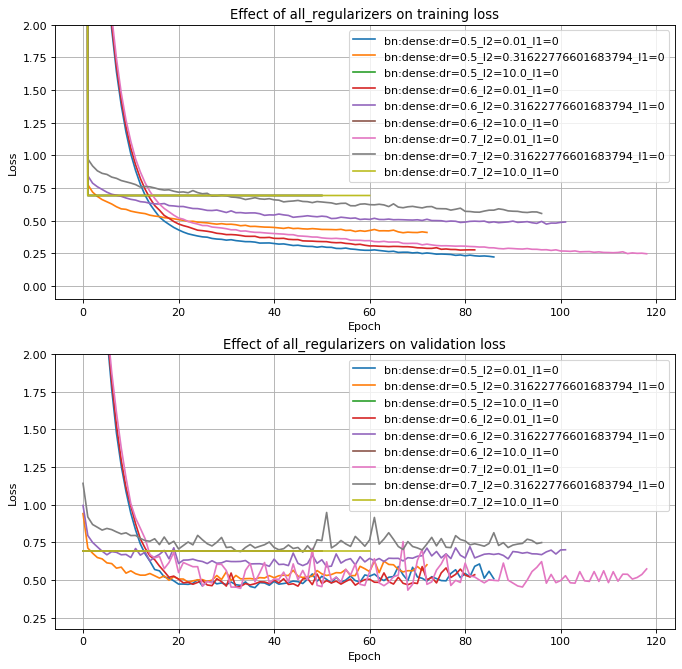

<Figure size 432x288 with 0 Axes>

In [31]:
ml_utils.plot_loss_by_param(all_regularizers, 'all_regularizers', 'all_regularizers_loss', ylim_right=2)

#### Accuracy

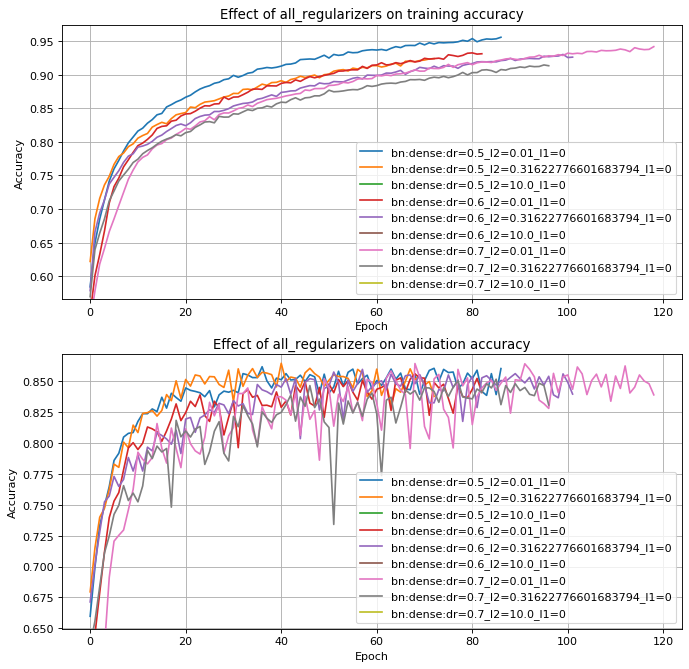

<Figure size 432x288 with 0 Axes>

In [32]:
ml_utils.plot_accuracies_by_param(all_regularizers, 'all_regularizers', 'all_regularizers_accuracy')

#### Generalization Gap

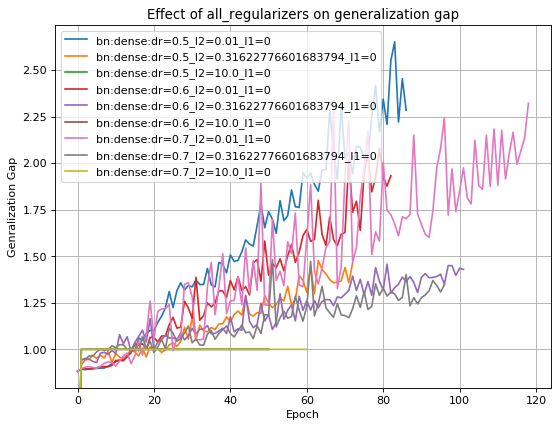

In [33]:
ml_utils.plot_generalization_gap_by_param(all_regularizers, 'all_regularizers', 'all_regularizers_gen_gap', 5)

#### Weight Visualization

Model: dense:dr=0_l2=0_l1=0, Max Weight: 0.15175209939479828, Min Weight: 0.15175209939479828
Model: dense:dr=0.4_l2=0_l1=0, Max Weight: 0.14278064668178558, Min Weight: 0.14278064668178558
Model: dense:dr=0_l2=0.01_l1=0, Max Weight: 0.070401132106781, Min Weight: 0.070401132106781
Model: dense:dr=0_l2=0_l1=0.001, Max Weight: 0.6767701506614685, Min Weight: 0.6767701506614685
Model: bn:dense:dr=0.5_l2=0.01_l1=0, Max Weight: 0.02868460677564144, Min Weight: 0.02868460677564144


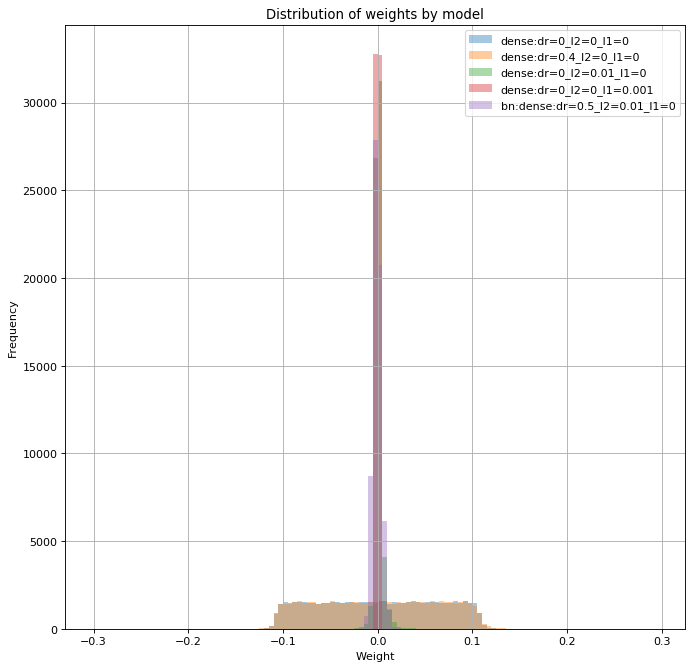

In [144]:
model_weights_by_regularizers = {}

for key in [
    'dense:dr=0_l2=0_l1=0', 
    'dense:dr=0.4_l2=0_l1=0', 
    'dense:dr=0_l2=0.01_l1=0', 
    'dense:dr=0_l2=0_l1=0.001', 
    'bn:dense:dr=0.5_l2=0.01_l1=0'
]:
    use_bn=False
    weight_index=12
    if key.startswith('bn:'):
        use_bn=True
        weight_index=40
    model = ml_utils.build_model(conv_dropout_rate=0, dense_dropout_rate=0, use_batch_normalization=use_bn)
    model.load_weights('pickled_objects/regularization/regularizers_{}_best_weights.h5'.format(key))
    model_weights_by_regularizers[key] = model.get_weights()[weight_index]
    
ml_utils.visualize_weights(model_weights_by_regularizers, 'weights_by_all_regularizers')

#### Activation Visualization

In [135]:
summarize_activations(stats_by_regularizer, all_regularizers, np_sample_batch)

Stats for bn:dense:dr=0.5_l2=0.01_l1=0 at convergence:  <utils.ml_utils.ModelState object at 0x7f7f20108ed0>
Non-zero Activations L(n-1): 90.84375, Average Activation L(n-1): 50.16057586669922
Non-zero Activations Ln: 130.4375, Average Activation Ln: 25.948408126831055

*********************************************************************

Stats for bn:dense:dr=0.5_l2=0.31622776601683794_l1=0 at convergence:  <utils.ml_utils.ModelState object at 0x7f7f2011e390>
Non-zero Activations L(n-1): 49.21875, Average Activation L(n-1): 21.637069702148438
Non-zero Activations Ln: 129.0625, Average Activation Ln: 9.267204284667969

*********************************************************************

Stats for bn:dense:dr=0.5_l2=10.0_l1=0 at convergence:  <utils.ml_utils.ModelState object at 0x7f7f20075810>
Non-zero Activations L(n-1): 38.65625, Average Activation L(n-1): 6.845478555713744e-26
Non-zero Activations Ln: 0.0, Average Activation Ln: 0.0

**********************************************

## Appendix

Type: dr=0_l2=0_l1=0, non-zero Activations: 107.875, Average Activation: 31.580801010131836
Type: dense:dr=0.2_l2=0_l1=0, non-zero Activations: 101.4375, Average Activation: 43.295108795166016
Type: dense:dr=0.4_l2=0_l1=0, non-zero Activations: 71.96875, Average Activation: 121.11151123046875
Type: dense:dr=0.5_l2=0_l1=0, non-zero Activations: 49.6875, Average Activation: 88.51631164550781


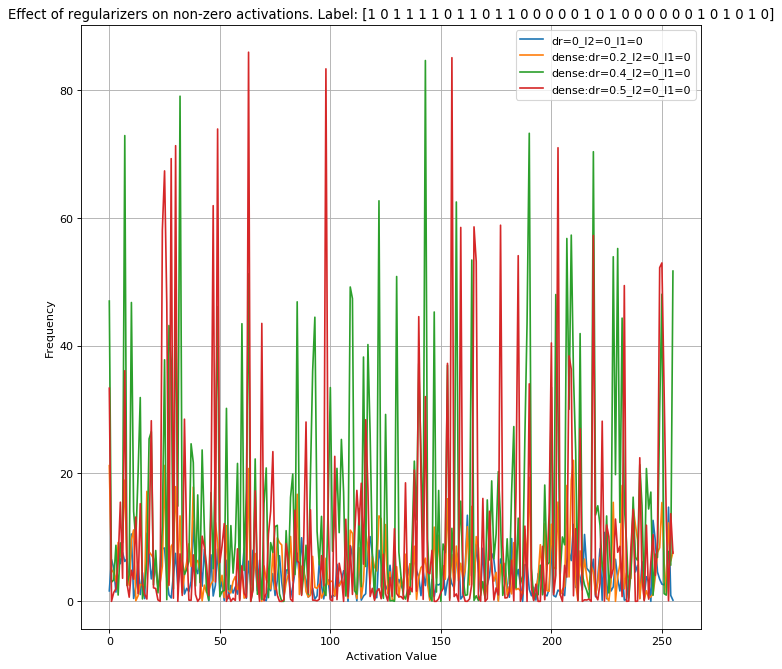

In [24]:
plt.figure(figsize=(10, 10), dpi=80)
bins=[0.1*a + 0.1 for a in range(200)]
non_zero_activation_16_dropout=np.zeros(256)
non_zero_activation_16_no_dropout=np.zeros(256)
non_zero_activation_18_dropout=np.zeros(256)
non_zero_activation_18_no_dropout=np.zeros(256)

for typ, (activation_16, activation_18, label) in activation_by_regularizers.items():
    if typ=='dr=0_l2=0.001_l1=0':
        continue
    activation_sum = np.sum(activation_18, axis=0)
    non_zero_activations = np.average(np.sum(activation_18>0, axis=1))
    average_activation = np.average(np.sum(activation_18, axis=1))
    print('Type: {typ}, non-zero Activations: {non_zero_activations}, Average Activation: {average_activation}'.
          format(typ=typ, non_zero_activations=non_zero_activations, average_activation=average_activation))
    plt.plot(range(256), activation_sum, label=str(typ))
    plt.xlabel('Activation Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.legend(loc='best')
    plt.title('Effect of {param_name} on non-zero activations. Label: {label}'.format(
        param_name='regularizers',
        label=label
    ))

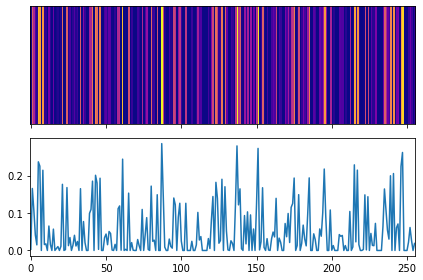

In [64]:
x = range(256)
y = activation_18[0]

fig, (ax,ax2) = plt.subplots(nrows=2, sharex=True)

extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
ax.imshow(y[np.newaxis,:], cmap="plasma", aspect="auto", extent=extent)
ax.set_yticks([])
ax.set_xlim(extent[0], extent[1])

ax2.plot(x,y)

plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

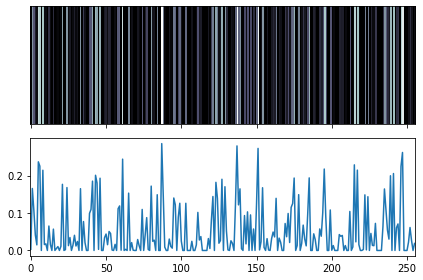

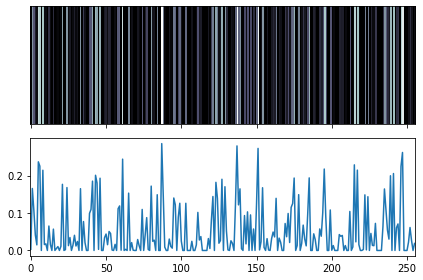

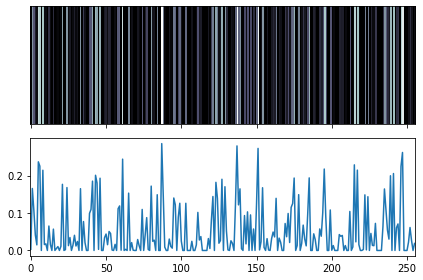

In [66]:
plt.figure()
x = range(256)

for i in range(1):
    for typ, (activation_16, activation_18, label) in activation_by_regularizers.items():
        fig, (ax,ax2) = plt.subplots(nrows=2, sharex=True)
        extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
        ax.imshow(y[np.newaxis,:], cmap=plt.cm.bone, aspect="auto", extent=extent)
        ax.set_yticks([])
        ax.set_xlim(extent[0], extent[1])

        ax2.plot(x,y)

        plt.tight_layout()
        plt.show()

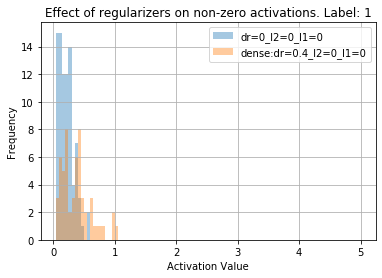

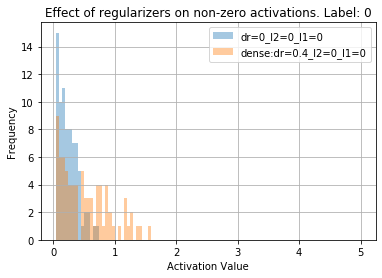

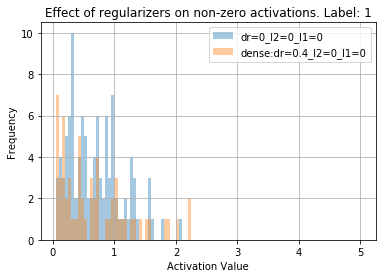

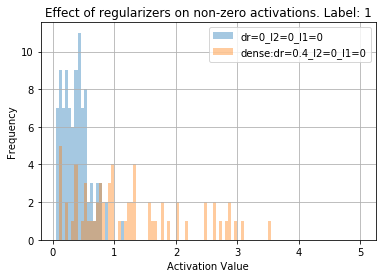

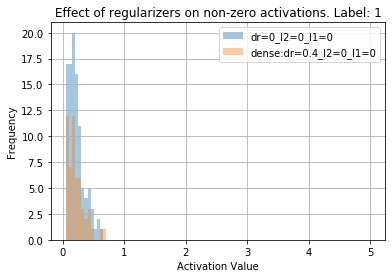

In [60]:
plt.figure()
#plt.title('Effect of {param_name} on non-zero activations'.format(param_name='regularizers'))
bins=[0.05*a + 0.05 for a in range(100)]

for i in range(5):
    for typ, (activation_16, activation_18, label) in activation_by_regularizers.items():
        if typ=='dr=0_l2=0.001_l1=0':
            continue
        sns.distplot(activation_18[i], label=str(typ), kde=False, bins=bins)
        plt.xlabel('Activation Value')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.legend(loc='best')
        plt.title('Effect of {param_name} on non-zero activations. Label: {label}'.format(
            param_name='regularizers',
            label=label[i]
        ))
    
    plt.show()